# Dimension reduction practice

Here, we will look at some toy data with dimension reduction methods.

## PCA

We will discuss some intuition behind principal component analysis. Our data is made up of some collection of measurements -- for example, say we are analyzing cars, and the data available to us are the car's weight, fuel tank size, engine size, and fuel efficiency. Rather than selecting and discarding variables, PCA transforms the data so that each car is described as a new set of characteristics/variables, and each one is a _linear combination_ of the original measurements. That is, PCA variable 1 is some constant `a1` multiplied by `car_weight` plus some other constant `a2` multiplied by `fuel_tank_size`, etc. PCA variable 2 is some constant `b1` multiplied by `car_weight` plus some other constant `b2` multiplied by `fuel_tank_size`, etc. The value of these constants is calculated so that the new PCA variables show the highest possible variation between the original variables.

Geometrically, what PCA does is take our data and rotate the axes so that they now line up with the directions of largest variance. It creates a _new orthogonal coordinate system_ so that the data are now uncorrelated. If you imagine your data as some cloud of points, what PCA does is draw an ellipse around all of your points, and then draw the axes of that ellipse. These axes are your principal axes and the basis of your new coordinate system. The axes are ranked from longest to shortest, because the longest represents the dimension in which your data varies the most.

Mathematically all of this is done using eigenanalysis. The directions of your principal axes will be given by your eigenvectors, and the covariance matrix in your transformed data is given by the eigenvalues:

$$Cov(transformed) = diag(\lambda_{1}, \lambda_{2}, \dots, \lambda_{p})$$

Where you have $p$ principal axes and your eigenvalues are $\lambda_{1} \ge \lambda_{2} \ge \dots \ge \lambda_{p}$. The total variance of the transformed is given by the sum $\sum_{i}^{p}\lambda_{i}$, so the amount of variance explained by component $j$ is $\frac{\displaystyle \lambda_{j}}{\displaystyle \sum_{i}^{p}\lambda_{i}}$.

Note that if your data exists in $N \times M$ dimensions, the number of principal axes will be the smaller of the two. There is an excellent discussion on the details and various intuition-based explanations [on a well-known stackexchange thread](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues).

There are a few considerations with PCA:
* PCA can be sensitive to outliers. One outlier can cause the variance in your data to be much larger.
* For similar reasons, data should be normalized before proceeding

### PCA with generated data

We can start with some artificial data to get an idea of what it means to rotate axes so that they explain the most variation.

In [1]:
# Set up so plots show up within the browser window
%matplotlib inline

# Import libraries
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
# This is a helper function to draw an ellipse (https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html)
# (ie this is not actually part of PCA)
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [3]:
# Helper function to draw a vector
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

In [4]:
# Fix a seed for reproducibility
random_seed = 202006
random_state = np.random.RandomState(random_seed)

# Generate our data
# Our data will be multivariate normal (2D) with mean vector (1,3) and covariance matrix ((7,5),(5,25))
X = random_state.multivariate_normal(mean = [1, 3], cov = [[7, 5],[5, 25]], size = 200)

(-7.710604925425679, 9.012471651290838, -11.056169720663865, 21.69637394272138)

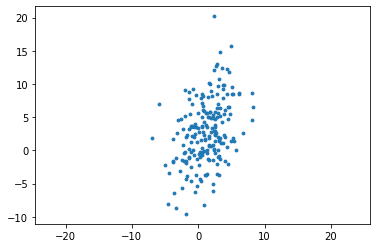

In [5]:
# Plot our data
plt.scatter(X[:,0], X[:,1], s=8)
plt.axis('equal')

In [6]:
# Transform our data using PCA
pca = PCA(n_components=2) # Create the PCA object in python
pca.fit(X) # Calculate the PC axes for the data we generated

# We have not yet transformed our data (we only have the principal axes)
# This command transforms our matrix, X, into the PCA space generated by X above
X_pca = pca.transform(X)

# You can also use pca.fit_transform() to do both steps at once.

We can look at the explained variance in our data using our `pca` object:

In [7]:
print("The explained variance per component is:", pca.explained_variance_)
print("The explained variance ratio per component is:", pca.explained_variance_ratio_)

The explained variance per component is: [25.23713527  5.60755159]
The explained variance ratio per component is: [0.8182004 0.1817996]


We can illustrate the ellipse around our data and the axes generated by PCA. Note that the ellipse being draw is technically a confidence ellipse and is not being fit exactly to the data, so it might look slightly off. The idea should be clear however.

[(-20, 25), (-30, 30)]

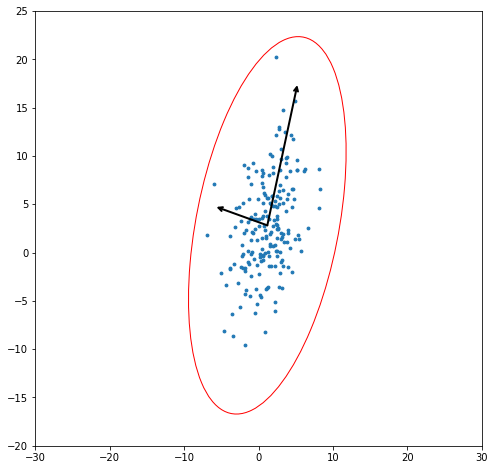

In [8]:
# Plot our data
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:,0], X[:,1], s=8,)
confidence_ellipse(X[:,0], X[:,1], ax, edgecolor='red', n_std = 4)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax)
ax.set(xlim=(-30,30), ylim=(-20,25))

Finally, we can look at our original data versus our transformed data.

[Text(0, 0.5, 'PC2'), Text(0.5, 0, 'PC1'), Text(0.5, 1.0, 'Transformed data')]

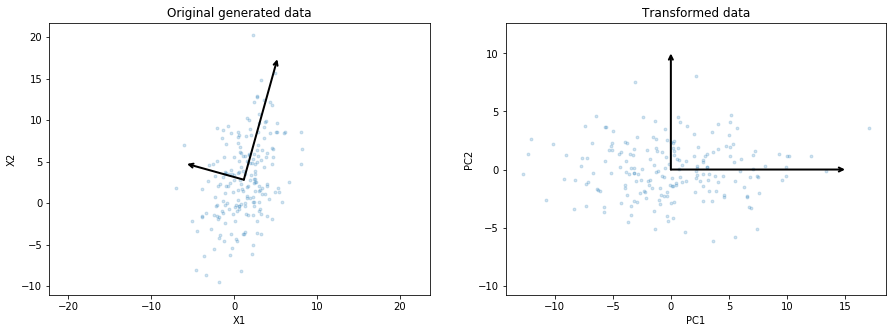

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the original random data we generated
ax[0].scatter(X[:,0], X[:,1], alpha=0.2, s=8)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='X1', ylabel='X2', title='Original generated data')

# Plot the data after it has been transformed into PCA space
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2, s=8)
draw_vector([0, 0], [0, 10], ax=ax[1])
draw_vector([0, 0], [15, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='PC1', ylabel='PC2',
          title='Transformed data')

### PCA with toy data

The generated data above shows how the mechanics of PCA work. Typically we are working beyond two dimensions. Here we will use the famous iris flower data set before moving on to genomic data. This data contains measurements of four variables in three species of flowers. By transforming this data with PCA, we can (hopefully!) see patterns in two dimensions that summarize how data various across four dimensions.

In [10]:
import pandas as pd

In [11]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "flower"]
iris_data = pd.read_csv(url, names=names)

# alternately, if this URL import doesn't work we can load the data but will have to do some formatting:
#from sklearn.datasets import load_iris
#iris_data = load_iris()

In [12]:
# Take a quick look at our data
iris_data

,sepal_length,sepal_width,petal_length,petal_width,flower
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [13]:
# Normalize our data
from sklearn.preprocessing import StandardScaler

# We only need the numerical variables
features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

# Extract the data from our datasets and standardize it
iris_X = iris_data.loc[:, features].values
iris_X = StandardScaler().fit_transform(iris_X)
iris_X = pd.DataFrame(iris_X)

Now we can do the PCA:

In [14]:
# Create the object and fit + transform the data
iris_pca = PCA()
iris_X_pca = iris_pca.fit_transform(iris_X)
iris_X_pca = pd.DataFrame(iris_X_pca)

# Take a look at the first few rows.
iris_X_pca.head()

,0,1,2,3
0,-2.264542,0.505704,-0.121943,-0.023073
1,-2.086426,-0.655405,-0.227251,-0.103208
2,-2.367950,-0.318477,0.051480,-0.027825
3,-2.304197,-0.575368,0.098860,0.066311
4,-2.388777,0.674767,0.021428,0.037397


In [15]:
# Look at the explained variance
print("The explained variance of the iris data is:", iris_pca.explained_variance_ratio_)

The explained variance of the iris data is: [0.72770452 0.23030523 0.03683832 0.00515193]


The first PC should explain around 72\% of the data, and the second around 23\%. These two combined explain almost 95\% of the variance and should show patterns in the data clearly.

Now that we have our PC coordinates, we can plot them.

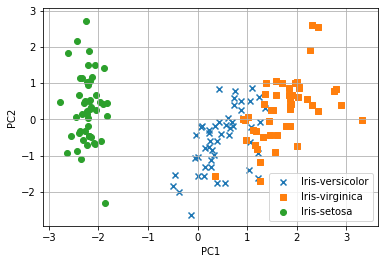

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel("PC1") 
ax.set_ylabel("PC2") 

# Convert the PCA coordinates from a pandas data frame to an array
iris_pc_coords = iris_X_pca.values

# Get the unique list of flower types in our dataset
flowers = list(set(iris_data.flower))

# Define colours for each flower
colours = ["r", "g", "b"]
markers = ["x","s","o"]

# This code will plot the data for each flower individually
for flower, colour, marker in zip(flowers, colours, markers):
    idx = iris_data["flower"]==flower # Get the indices of types of flowers
    ax.scatter(iris_pc_coords[idx,0], iris_pc_coords[idx,1], marker = marker)
    
ax.legend(flowers)
ax.grid()

By taking our four original variables and reducing them to two , we still manage to preserve 95% of the data and see how strongly correlated the PCs are to flower type.

## t-SNE and UMAP

t-SNE and UMAP are different dimension reduction methods that are closely related in theory. They are both neighbour graph approaches, which is to say that rather than trying to trying to fit to all of the data at once like PCA, they connect points into graphs and try to keep neighbours together. This approach is useful when there is some underlying structure to our data that is non-linear. However, by focusing on this neighbour approach, our method will focus mostly on _local structure_. This means we will introduce artficial tearing into our space, and that long-range distances are not well preserved.

The general idea of both approaches is that we connect some neighbouring points in high-dimensional space, and we try to preserve these neighbouring connections in low-dimensional space. Key differences include how you define how close a neighbour should be, and how you decide to build these connections in low-dimensional space. Once the low-dimensional space is calculated, we try to make the differences between points in high- and low-dimensional space as small as possible. That is, we wish to create a faithful representation of the structure in high-dimensional space.

In t-SNE, the high-dimensional distance is estimated with probabilities following a Gaussian distribution, so closer points have a higher probability of being close than those that are farther. Users specify a "perplexity", which is the variance of your Gaussian -- a bigger perplexity means a bigger Gaussian, which means points can have more neighbours. The low-dimensional distance is estimated by the t-distribution.

In UMAP, users specify the number of neighbours (say, $k$) they wish each point to have, and the algorithm constructs a simplicial set. More simply, for each point it connects the $k$ nearest neighbours with lines, creating sort of a mesh of data. Note that since each point has its own measurement of distance (my 15th-nearest neighbour might not be as far as your 15th-nearest neighbour), there is some simple-yet-fancy math behind the scenes to create a consistent distance measure. Users also select the minimum distance they wish for points to have between them in low-dimensional space, and the algorithm creates an embedding (another "mesh") of data that best reflects the high-dimensional simplicial set.

Both of these methods are very popular, though UMAP tends to be faster and possibly easier to comprehend. For a walkthrough of the UMAP algorithm, [the documentation is very useful](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html). The original paper for t-SNE gives some intuition for how it works. The original paper for UMAP is fairly technical but the math can be useful for understanding connections between the methods.
* [Visualizing data with t-SNE](http://www.jmlr.org/papers/v9/vandermaaten08a.html) (van der Maaten et al, 2005)
* [UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction
](https://arxiv.org/abs/1802.03426) (McInnes et al, 2018)
* [An interactive visualization of how UMAP and t-SNE work and differ](https://pair-code.github.io/understanding-umap/)

### With generated data

We will use the built-in data and examples available in the `sklearn` library. This data obviously has a structure to it in three dimensions (a roll shape), but this will not be captured by methods like PCA.

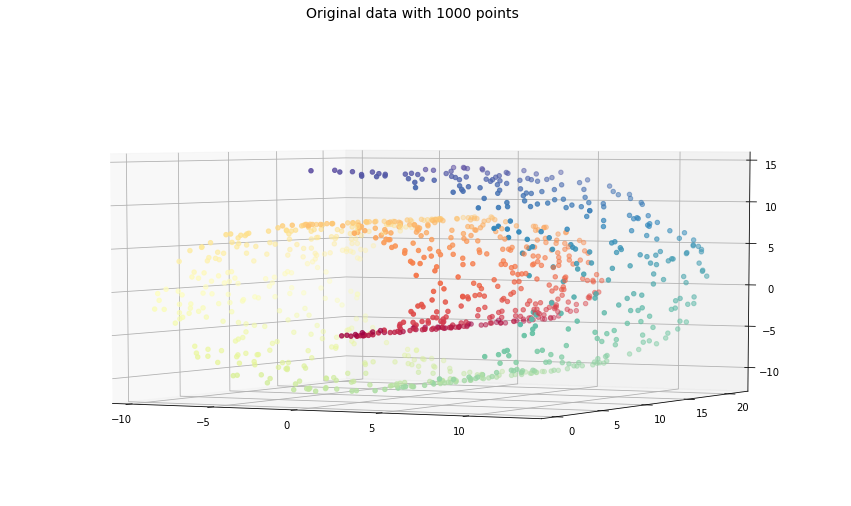

In [17]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html

from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_swiss_roll(n_points, random_state=0)
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Original data with %i points"
             % (n_points), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -62)

In [18]:
# Carry out the dimension reduction methods
random_seed = 202006

swiss_pca = PCA()
swiss_pca = swiss_pca.fit_transform(X)

swiss_tsne = manifold.TSNE(n_components=2, perplexity=30, init='pca', random_state=random_seed)
swiss_tsne = swiss_tsne.fit_transform(X)

swiss_umap = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=random_seed)
swiss_umap = swiss_umap.fit_transform(X)

NameError: name 'umap' is not defined

In [ ]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(131)
ax.scatter(swiss_pca[:, 0], swiss_pca[:, 1], c=color, cmap=plt.cm.Spectral)
ax.set_title("PCA")

ax = fig.add_subplot(132)
ax.scatter(swiss_tsne[:, 0], swiss_tsne[:, 1], c=color, cmap=plt.cm.Spectral)
ax.set_title("t-SNE")

ax = fig.add_subplot(133)
ax.scatter(swiss_umap[:, 0], swiss_umap[:, 1], c=color, cmap=plt.cm.Spectral)
ax.set_title("UMAP")

Here we see that PCA loses the underlying manifold structure of our data, whereas t-SNE and UMAP manage to keep the points that were originally closer near to each other. Also take note that t-SNE and UMAP have both introduced artificial clusters. Always make multiple runs with different parameterizations!

### With iris data

In [ ]:
iris_tsne = manifold.TSNE(n_components=2, perplexity=30, init='pca', random_state=random_seed)
iris_tsne = iris_tsne.fit_transform(iris_X.values)

iris_umap = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=random_seed)
iris_umap = iris_umap.fit_transform(iris_X.values)

In [ ]:
# Plot the results

# Get the unique list of flower types in our dataset
flowers = list(set(iris_data.flower))

# Define colours for each flower
colours = ["r", "g", "b"]
markers = ["x","s","o"]

# Set up the figure

fig = plt.figure(figsize=(15, 5))

# PCA
ax = fig.add_subplot(131) 
ax.set_xlabel("PC1") 
ax.set_ylabel("PC2") 

# Convert the PCA coordinates from a pandas data frame to an array
iris_pc_coords = iris_X_pca.values

for flower, colour, marker in zip(flowers, colours, markers):
    idx = iris_data["flower"]==flower
    ax.scatter(iris_pc_coords[idx,0], iris_pc_coords[idx,1], marker = marker)
    
ax.legend(flowers)
ax.grid()

# t-SNE

ax = fig.add_subplot(132) 

ax.set_xlabel("tsne1") 
ax.set_ylabel("tsne2") 

# Get the unique list of flower types in our dataset
flowers = list(set(iris_data.flower))

# Define colours for each flower
colours = ["r", "g", "b"]
markers = ["x","s","o"]

# This code will plot the data for each flower individually
for flower, colour, marker in zip(flowers, colours, markers):
    idx = iris_data["flower"]==flower # Get the indices of types of flowers
    ax.scatter(iris_tsne[idx,0], iris_tsne[idx,1], marker = marker)
    
ax.legend(flowers)
ax.grid()

# UMAP
ax = fig.add_subplot(133) 

ax.set_xlabel("umap1") 
ax.set_ylabel("umap2") 

# Get the unique list of flower types in our dataset
flowers = list(set(iris_data.flower))

# Define colours for each flower
colours = ["r", "g", "b"]
markers = ["x","s","o"]

# This code will plot the data for each flower individually
for flower, colour, marker in zip(flowers, colours, markers):
    idx = iris_data["flower"]==flower # Get the indices of types of flowers
    ax.scatter(iris_umap[idx,0], iris_umap[idx,1], marker = marker)
    
ax.legend(flowers)
ax.grid()